In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
os.listdir('./../Dataset_Student/train/video_0/')

['image_15.png',
 'image_14.png',
 'image_16.png',
 'image_17.png',
 'image_13.png',
 'image_12.png',
 'image_10.png',
 'image_11.png',
 'image_8.png',
 'image_9.png',
 'mask.npy',
 'image_2.png',
 'image_3.png',
 'image_1.png',
 'image_0.png',
 'image_4.png',
 'image_5.png',
 'image_7.png',
 'image_6.png',
 'image_20.png',
 'image_21.png',
 'image_19.png',
 'image_18.png']

In [3]:
# Video 1

frames = []

base_dir = './../Dataset_Student/train/video_0/'

image_names = [f'image_{i}.png' for i in range(22)]

for file_name in image_names:
    img = plt.imread(base_dir + file_name)
    frames.append(img)

mask = np.load(base_dir + 'mask.npy')


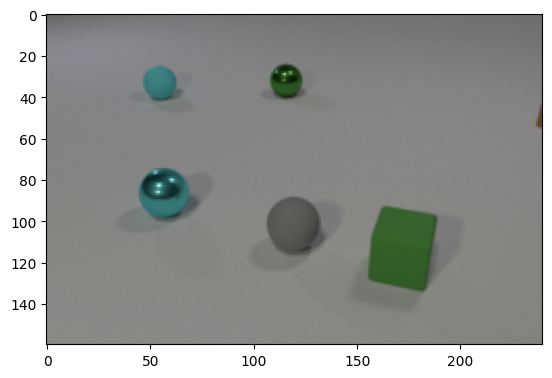

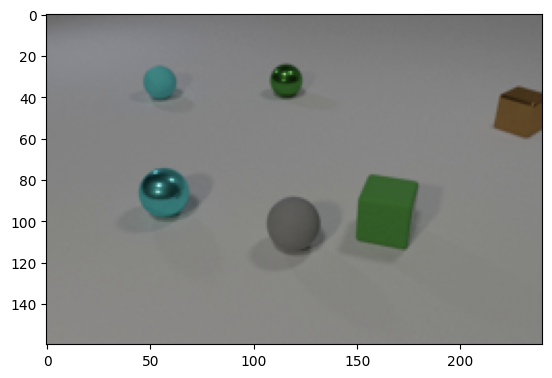

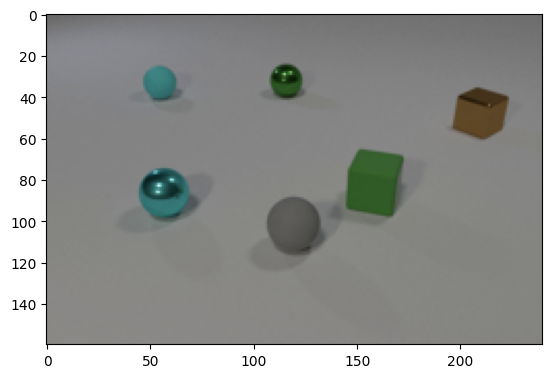

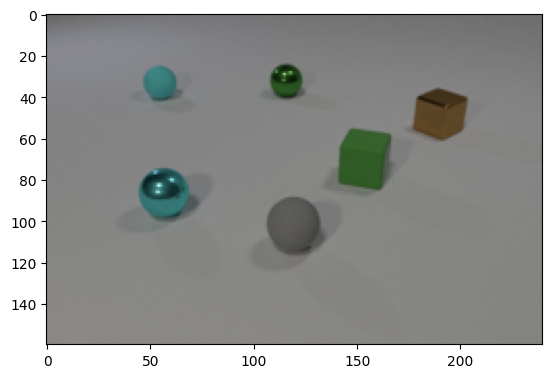

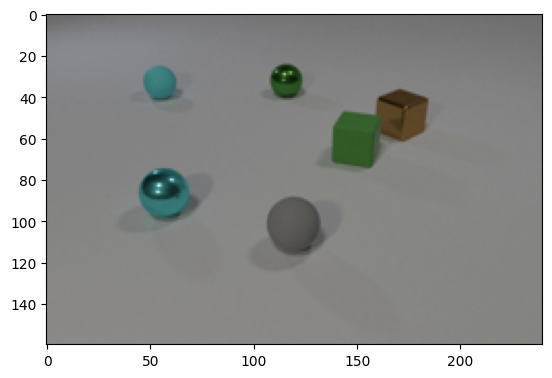

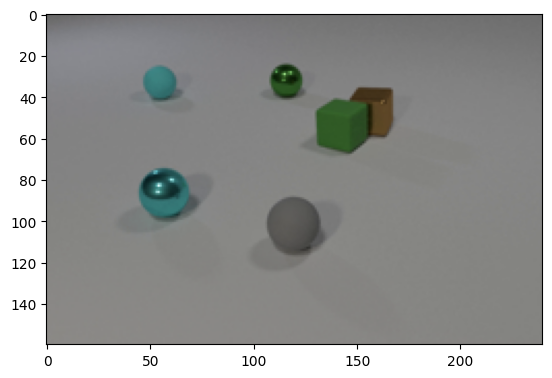

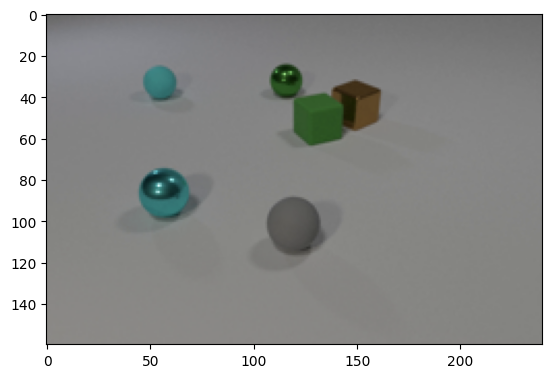

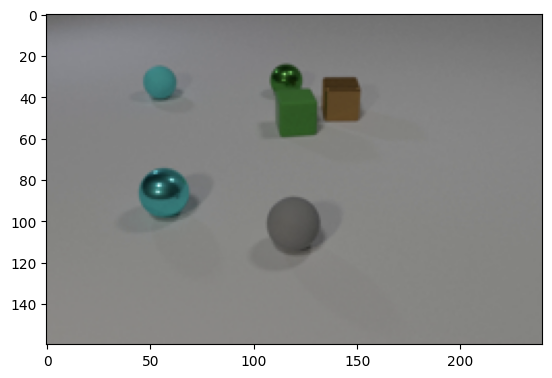

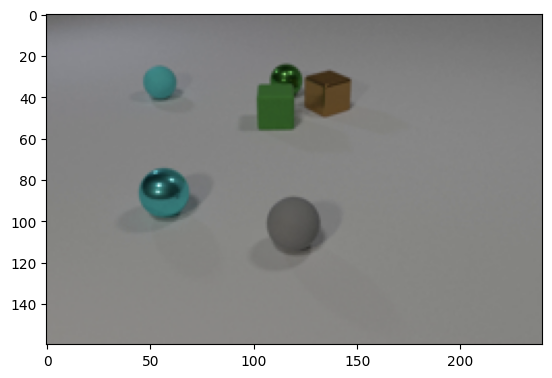

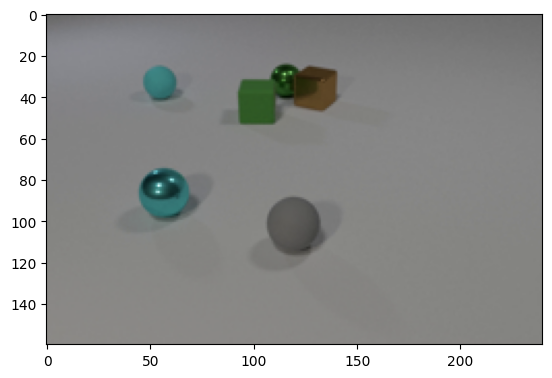

In [4]:
for i in range(10):
    plt.figure()
    plt.imshow(frames[i])

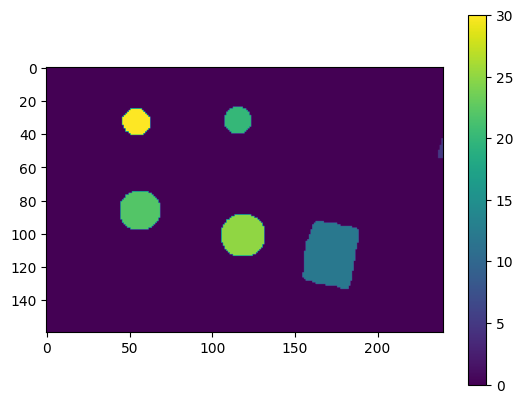

In [5]:
plt.imshow(mask[0])
plt.colorbar()

In [6]:
frames[0].shape

(160, 240, 3)

In [7]:
np.unique(mask)

array([ 0,  5, 12, 20, 22, 25, 30], dtype=uint8)

# Data Preprocessing

Shapes:<br>
- Cube
- Sphere
- Cylinder
<br><br><br>
Materials:<br>
- Metal
- Rubber
<br><br><br>
Colors:<br>
1. Gray
2. Red
3. Blue
4. Green
5. Brown
6. Cyan
7. Purple
8. Yellow

## Mask value -> (Shape, Material, Color)

1. 0 -> (0,0,0)
2. 

In [8]:
image_test = frames[0]
image_mask = mask[0]
print(image_test.shape, image_mask.shape)

(160, 240, 3) (160, 240)


In [9]:
image_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
image_test

array([[[0.40392157, 0.40392157, 0.4       ],
        [0.4117647 , 0.4117647 , 0.4117647 ],
        [0.40784314, 0.40784314, 0.40784314],
        ...,
        [0.43137255, 0.42745098, 0.43137255],
        [0.42352942, 0.42352942, 0.42352942],
        [0.42745098, 0.42745098, 0.42745098]],

       [[0.4       , 0.4       , 0.39215687],
        [0.4117647 , 0.4117647 , 0.40784314],
        [0.40392157, 0.40392157, 0.40392157],
        ...,
        [0.43529412, 0.43529412, 0.43529412],
        [0.42352942, 0.42352942, 0.42352942],
        [0.43137255, 0.43137255, 0.43137255]],

       [[0.40392157, 0.40392157, 0.40392157],
        [0.41568628, 0.41568628, 0.41568628],
        [0.41960785, 0.41960785, 0.41960785],
        ...,
        [0.43137255, 0.43137255, 0.43137255],
        [0.42745098, 0.42745098, 0.42745098],
        [0.42745098, 0.42745098, 0.42745098]],

       ...,

       [[0.54509807, 0.5372549 , 0.5294118 ],
        [0.54509807, 0.5372549 , 0.5254902 ],
        [0.54509807, 0

# Model

In [11]:
a = torch.tensor(range(10))
print(a)
b = a.clone().detach()
print(b)
a[1] = 10
print(a)
print(b)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([ 0, 10,  2,  3,  4,  5,  6,  7,  8,  9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [12]:
class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        
        # Branch Connectors
        self.bc_u1_c2 = nn.ConvTranspose2d(64,64, kernel_size=4, stride=2, padding=1)
        self.bcnorm1 = nn.BatchNorm2d(64)
        
        self.bc_u2_c3 = nn.ConvTranspose2d(128,128, kernel_size=4, stride=4, padding=0)
        self.bcnorm2 = nn.BatchNorm2d(128)
        
        self.bc_u3_c4 = nn.ConvTranspose2d(256,256, kernel_size=8, stride=8, padding=0)
        self.bcnorm3 = nn.BatchNorm2d(256)
        
        self.bc_u4_c5 = nn.ConvTranspose2d(512,512, kernel_size=8, stride=8, padding=0)
        self.bcnorm4 = nn.BatchNorm2d(512)
        
        self.bc_u5_c6 = nn.ConvTranspose2d(512,256, kernel_size=4, stride=4, padding=0)
        self.bcnorm5 = nn.BatchNorm2d(256)
        
        self.bc_u6_c7 = nn.ConvTranspose2d(256,128, kernel_size=4, stride=2, padding=1)
        self.bcnorm6 = nn.BatchNorm2d(128)
        
        
        # First branch of the network

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(64*2, 128, kernel_size=5, padding=2)
        self.bnorm1 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128*2, 256, kernel_size=9, padding=4)
        
        self.conv4 = nn.Conv2d(256*2, 512, kernel_size=15, padding=7)
        self.bnorm2 = nn.BatchNorm2d(512)

        self.conv5 = nn.Conv2d(512*2, 256, kernel_size=15, padding=7)
        self.bnorm3 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(256*2,128, kernel_size=9, padding=4)
        
        self.conv7 = nn.Conv2d(128*2,64, kernel_size=5, padding=2)
        self.bnorm4 = nn.BatchNorm2d(64)
                
        
        # Second branch of the network
        # b, 3, 160, 240
        self.uconv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)

        # b, 64, 80, 120
        self.uconv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.ump1 = nn.MaxPool2d(kernel_size= 2)
        self.ubnorm1 = nn.BatchNorm2d(128)
        
        # b, 128, 40, 60
        self.uconv3 = nn.Conv2d(128, 256, kernel_size=9, padding=4)
        self.ump2 = nn.MaxPool2d(kernel_size= 2)
        
        # b, 256, 20, 30
        self.uconv4 = nn.Conv2d(256, 512, kernel_size=15, padding=7)
        self.ubnorm2 = nn.BatchNorm2d(512)

        # b, 512, 20, 30
        self.uconv5 = nn.Conv2d(512, 256, kernel_size=15, padding=7)
        self.ubnorm3 = nn.BatchNorm2d(256)
        self.upsamp1 = nn.ConvTranspose2d(256,512, kernel_size=4, stride=2, padding=1)
        
        # b, 512, 40, 60
        self.uconv6 = nn.Conv2d(512,256, kernel_size=9, padding= 4)
        self.upsamp2 = nn.ConvTranspose2d(256,256, kernel_size=4, stride=2, padding=1)
        
        # b, 256, 80, 120
        self.uconv7 = nn.Conv2d(256,128, kernel_size=5, padding = 2)
        self.upsamp3 = nn.ConvTranspose2d(128,64, kernel_size=4, stride=2, padding=1)
        self.ubnorm4 = nn.BatchNorm2d(64)
        # b, 64, 160, 240
        
        
        # Final layer of the network
        # x: b, 64, 160, 240 and x_u: b, 64, 160, 240
        # Overall input shape for final layer: b, 128, 160, 240
        self.conv8 = nn.Conv2d(64*2, num_classes, kernel_size=3, padding = 1)

        
        
    def forward(self, x):
        
        
        x_u = x.clone()
        print(f'x: {x.shape}, x_u: {x_u.shape}')
        
        # LAYER 1
        # x: batch, 3, 160, 240
        # x_u: batch, 3, 160, 240
        x = self.conv1(x)
        x = F.relu(x)

        x_u = self.uconv1(x_u)
        x_u = F.relu(x_u)
#         print('uconv 1:',x_u.shape)
        

        # LAYER 2
        # x: batch, 64, 160, 240
        # x_u: batch, 64, 80, 120
        print(f'x: {x.shape}, x_u: {x_u.shape}')
        x_u_upsampled = self.bc_u1_c2(x_u)
        x = torch.cat([x,x_u_upsampled], axis = 1)
        x = self.conv2(x)
        x = self.bnorm1(x)
        x = F.relu(x)
        
        x_u = self.uconv2(x_u)
        x_u = self.ump1(x_u)
        x_u = self.ubnorm1(x_u)
        x_u = F.relu(x_u)
#         print('uconv 2:',x_u.shape)
        
        

        # LAYER 3
        # x: batch, 128, 160, 240
        # x_u: batch, 128, 40, 60
        print(f'x: {x.shape}, x_u: {x_u.shape}')
        x_u_upsampled = self.bc_u2_c3(x_u)
        x = torch.cat([x,x_u_upsampled], axis = 1)
        x = self.conv3(x)
        x = F.relu(x)
        
        x_u = self.uconv3(x_u)
        x_u = self.ump1(x_u)
        x_u = F.relu(x_u)
#         print('uconv 3:',x_u.shape)

        

        # LAYER 4
        # x: batch, 256, 160, 240
        # x_u: batch, 256, 20, 30
        print(f'x: {x.shape}, x_u: {x_u.shape}')
        x_u_upsampled = self.bc_u3_c4(x_u)
#         print(x_u_upsampled.shape)
        x = torch.cat([x,x_u_upsampled], axis = 1)
        x = self.conv4(x)
        x = self.bnorm2(x)
        x = F.relu(x)

        x_u = self.uconv4(x_u)
        x_u = self.ubnorm2(x_u)
        x_u = F.relu(x_u)
#         print('uconv 4:',x_u.shape)   

        

        # LAYER 5
        # x: batch, 512, 160, 240
        # x_u: batch, 512, 20, 30
        print(f'x: {x.shape}, x_u: {x_u.shape}')
        x_u_upsampled = self.bc_u4_c5(x_u)
        x = torch.cat([x,x_u_upsampled], axis = 1)
        x = self.conv5(x)
        x = self.bnorm3(x)
        x = F.relu(x)

        x_u = self.uconv5(x_u)
#         print(x.shape)
        x_u = self.ubnorm3(x_u)
        x_u = self.upsamp1(x_u)
        x_u = F.relu(x_u)
#         print('uconv 5:',x_u.shape)
        
        

        # LAYER 6
        # x: batch, 256, 160, 240
        # x_u: batch, 256, 40, 60
        print(f'x: {x.shape}, x_u: {x_u.shape}')
        x_u_upsampled = self.bc_u5_c6(x_u)
        x = torch.cat([x,x_u_upsampled], axis = 1)
        x = self.conv6(x)
        x = F.relu(x)

        x_u = self.uconv6(x_u)
        x_u = self.upsamp2(x_u)
        x_u = F.relu(x_u)
#         print('uconv 6:',x_u.shape)

        

        # LAYER 7
        # x: batch, 128, 160, 240
        # x_u: batch, 128, 80, 120
        print(f'x: {x.shape}, x_u: {x_u.shape}')
        x_u_upsampled = self.bc_u6_c7(x_u)
        x = torch.cat([x,x_u_upsampled], axis = 1)
        x = self.conv7(x)
        x = F.relu(x)
        x = self.bnorm4(x)

        x_u = self.uconv7(x_u)
        x_u = F.relu(x_u)
        x_u = self.upsamp3(x_u)
        x_u = self.ubnorm4(x_u)
#         print('uconv 7:',x_u.shape)


        
        # LAYER 8 : Final
        # x: batch, 64, 160, 240
        # x_u: batch, 64, 160, 240
        print(f'x: {x.shape}, x_u: {x_u.shape}')
        x_u_upsampled = self.bc_u6_c7(x_u)
        x = torch.cat([x,x_u_upsampled], axis = 1)
        x = self.conv8(x)
        print('Final:',x.shape)
        
        # x: batch, 49, 160, 240
        return F.softmax(x, dim=1)

# Instantiate the model
num_classes = 48 + 1
model = FCN(num_classes)

# Example usage
# image_test = torch.randn(1, 3, 160, 240)  # Batch size of 1, 3 channels, and image size (160, 240)
image_test = torch.tensor(frames).permute(0,3,1,2) #frames[0]

output_mask = model(image_test)

print("Input shape:", image_test.shape)
print("Output shape:", output_mask.shape)


/var/folders/jq/tjhgv6nd5cv165gc1bvctnlr0000gn/T/ipykernel_56176/873382748.py:225: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  image_test = torch.tensor(frames).permute(0,3,1,2) #frames[0]


x: torch.Size([22, 3, 160, 240]), x_u: torch.Size([22, 3, 160, 240])
x: torch.Size([22, 64, 160, 240]), x_u: torch.Size([22, 64, 80, 120])
x: torch.Size([22, 128, 160, 240]), x_u: torch.Size([22, 128, 40, 60])
x: torch.Size([22, 256, 160, 240]), x_u: torch.Size([22, 256, 20, 30])
torch.Size([22, 256, 160, 240])
x: torch.Size([22, 512, 160, 240]), x_u: torch.Size([22, 512, 20, 30])
x: torch.Size([22, 256, 160, 240]), x_u: torch.Size([22, 512, 40, 60])
x: torch.Size([22, 128, 160, 240]), x_u: torch.Size([22, 256, 80, 120])
uconv 7: torch.Size([22, 64, 160, 240])
x: torch.Size([22, 64, 160, 240]), x_u: torch.Size([22, 64, 160, 240])


RuntimeError: Given transposed=1, weight of size [256, 128, 4, 4], expected input[22, 64, 160, 240] to have 256 channels, but got 64 channels instead

In [ ]:
import torch.nn as nn

# Assuming you want to eightfold the spatial dimensions (stride=8)
upsample_layer = nn.ConvTranspose2d(
    in_channels=256,
    out_channels=256,
    kernel_size=4,  # Adjust the kernel size as needed
    stride=2,       # Adjust the stride to achieve the desired spatial dimensions
    padding=1   # Adjust padding to achieve the desired output shape
)

# Example usage:
batch_size = 5
input_tensor = torch.randn((batch_size, 256, 80, 120))
output_tensor = upsample_layer(input_tensor)

# Check the shape of the output
print(output_tensor.shape)


In [ ]:
image_mask.shape

In [15]:
all_sequences = []
all_sequence_masks = []
for i in range(10):
    frames = torch.tensor([])
    base_dir = f"./../Dataset_Student/train/video_{i}/"
    image_names = [f'image_{i}.png' for i in range(22)]
    for file_name in image_names:
        img = plt.imread(base_dir + file_name)
        frames = torch.cat([frames,torch.tensor(img).unsqueeze(0)], dim = 0)
    all_sequences.append(torch.tensor(frames))
    mask = np.load(base_dir + 'mask.npy')
    all_sequence_masks.append(torch.tensor(mask))
    
all_frames = torch.cat([i for i in all_sequences], dim = 0)
all_masks = torch.cat([i for i in all_sequence_masks], dim = 0)

/var/folders/jq/tjhgv6nd5cv165gc1bvctnlr0000gn/T/ipykernel_54883/2758756593.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_sequences.append(torch.tensor(frames))


In [16]:
# len(all_masks),all_masks[0].shape
# torch.cat([i for i in all_sequence_masks], dim = 0).shape


In [17]:

class CustomDataset(Dataset):
    def __init__(self, all_frames, all_masks):
        self.frames = torch.tensor(all_frames).permute(0, 3, 1, 2)
        self.masks = all_masks #torch.stack([ohe_mask(mask) for mask in all_masks]).permute(0,3,1,2)

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        mask = self.masks[idx]
        return frame, mask

# Hyperparameters
num_classes = 49
batch_size = 8
learning_rate = 0.001
num_epochs = 10

# Instantiate the model and set up the optimizer and loss function
model = FCN(num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Create DataLoader
train_dataset = CustomDataset(all_frames, all_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



/var/folders/jq/tjhgv6nd5cv165gc1bvctnlr0000gn/T/ipykernel_54883/2163246065.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.frames = torch.tensor(all_frames).permute(0, 3, 1, 2)


In [18]:
model.cuda()

AssertionError: Torch not compiled with CUDA enabled

In [35]:
help(torch.Tensor.cuda(all_frames))

AssertionError: Torch not compiled with CUDA enabled

In [19]:
# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for images, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
#         masks = masks.argmax(dim=1)
        masks = masks.long()
        print(outputs.shape, masks.shape)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}")

# Save the trained model if needed
torch.save(model.state_dict(), 'fcn_model.pth')


KeyboardInterrupt: 

In [75]:
x,y = train_dataset.__getitem__(0)
print(x.shape, y.shape)

torch.Size([3, 160, 240]) torch.Size([160, 240, 49])


In [ ]:
outputs

In [ ]:
masks